**Supervised transfer learning to classify individual brook trout**

In [1]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
os.chdir('/home/jovyan/IndID_BKT1/') # set working directory

In [3]:
# import libraries
import os 
import numpy as np
import random
import glob
import json
#import petname
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

# data preprocessing
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize

# Deep learning model specific library imports
from keras.applications import resnet_v2
from keras import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint

**Load the data**

In [4]:
def bounding_box(poly):
    '''
    Returns a bounding box from a polygon.
    '''
    minx = np.min(np.array(poly['all_points_x']))
    maxx = np.max(np.array(poly['all_points_x']))
    miny = np.min(np.array(poly['all_points_y']))
    maxy = np.max(np.array(poly['all_points_y']))
    width = maxx - minx
    height = maxy - miny
    
    return [minx, miny, width, height]

In [5]:
def extract_boxes(xy):
    '''
    Returns a bounding box from a polygon.
    Specifically, we return lower left coordinate, width and height.
    '''
    minx = xy['x']
    miny = xy['y']
    width = xy['width']
    height = xy['height']

    return [minx, miny, width, height]

In [6]:
def get_train_test_val():
    '''
    Load the fish data.
    Split data into train, validation and test sets.
    Leave out one image per class for validation & testing.
    '''
    # set random seed so we can reproduce the split
    random.seed(42)
    
    # sets to store test and validation images
    test = []
    val = []
    
    # nested list of lists - will flatten at the end to create a train set
    trn = []

    for i in range(1, 28):
        lst = glob.glob('/home/jovyan/IndID_BKT1/Photos/' + 'BKT1_' + str(i).zfill(3) + '*.jpg')

        # choose a random image to go into test set
        test_img = random.randint(0, len(lst) - 1)
        test.append(lst[test_img])
        # remove that image from train
        lst.pop(test_img)
        
        # choose a random image to go into validation set
        val_img = random.randint(0, len(lst) - 1)
        val.append(lst[val_img])
        # remove that image
        lst.pop(val_img)
        
        # add remaining images to train list
        trn.append(lst)

    # flatten the train list
    train = [item for sublist in trn for item in sublist]

    return train, test, val

In [7]:
def get_train_test_val2():
    
    for i in range(1, 28):
        
        lst = glob.glob('../../Photos/' + 'BKT1_' + str(i).zfill(3) + '*.jpg')
        
        # choose a random image to go into test set
        test_img = random.randint(0, len(lst) - 1)
        test.append(lst[test_img])
         
        # remove that image from train
        lst.pop(test_img)
        
        # choose a second random image to go into test set
        test_img = random.randint(0, len(lst) - 1)
        test.append(lst[test_img])
        
        # remove that image from train
        lst.pop(test_img)

        # choose a random image to go into validation set
        val_img = random.randint(0, len(lst) - 1)
        val.append(lst[val_img])
        
        # remove that image
        lst.pop(val_img)

        # choose a second random image to go into validation set
        val_img = random.randint(0, len(lst) - 1)
        val.append(lst[val_img])

        # remove that image
        lst.pop(val_img)

        # add remaining images to train list
        trn.append(lst)

        # flatten the train list
        train = [item for sublist in trn for item in sublist]

In [8]:
def data_xy_split(dataset, width, height):
    '''
    Input train, val or test dataset 
    and returns X_train, y_train or X_val, y_val or X_test, y_test
    4D array for X with number of images, width, height, channels
    1D array for y with fish IDs
    '''
    # X is a numpy array of images to return - could be train, test or val set
    X = np.empty([len(dataset), width, height, 3])
    
    # y is a numpy array of fish id's (0, ... , 26)
    y = np.empty(len(dataset), )
    
    # loop over images in dataset
    for i in range(len(dataset)):        
        img = mpimg.imread(dataset[i])  # read in image
        fishid = dataset[i][36:39] # read fish id from file name
        y[i] = round(int(fishid[1:3]) - 1) # append fish id to y list
        tnum = dataset[i][40:42] # read time code from file name

        # read in annotations  
        with open('/home/jovyan/IndID_BKT1/Annotations/BKT1_' + fishid + '_' + tnum + '.json') as f:
            ann = json.load(f)
        
        # get x and y coordinates for bounding boxes   
        xy = ann[ list(ann.keys())[0] ]['regions'][0]['shape_attributes']
        bbox = extract_boxes(xy)
       
        # crop image
        cropped_img = img[bbox[1] : (bbox[1] + bbox[3]), bbox[0]: (bbox[0] + bbox[2]), : ]

        # resize to square
        image_resized = resize(image = cropped_img, output_shape = (width, height, 3), anti_aliasing = True)
        
        # add images to the numpy array
        X[i, :, :, :] = image_resized

    return X, y

In [9]:
# make a list of cropped, resized and rescaled images for train, test and val sets
train, test, val = get_train_test_val()

In [10]:
print(len(train))
print(len(test))
print(len(val))

108
27
27


In [11]:
%%time
# define the size of resized input images 
width = 256
height = 256

# get train, test and validation data sets into 4D numpy arrays
X_train, y_train = data_xy_split(dataset = train, width = width, height = height)
X_test, y_test = data_xy_split(dataset = test, width = width, height = height)
X_val, y_val = data_xy_split(dataset = val, width = width, height = height)

CPU times: user 13.4 s, sys: 202 ms, total: 13.6 s
Wall time: 15.5 s


In [12]:
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('shape of train image: ', X_train[0].shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)
print('X val shape: ', X_val.shape)
print('y val shape: ', y_val.shape)

X train shape:  (108, 256, 256, 3)
y train shape:  (108,)
shape of train image:  (256, 256, 3)
X test shape:  (27, 256, 256, 3)
y test shape:  (27,)
X val shape:  (27, 256, 256, 3)
y val shape:  (27,)


In [13]:
# value range of training image - for training should be [0, 1]
print(np.max(X_train[0]))
print(np.min(X_train[0]))
print(np.max(X_test[0]))
print(np.min(X_test[0]))

0.9882352941176471
0.030537683823529414
0.996078431372549
0.05553002450980529


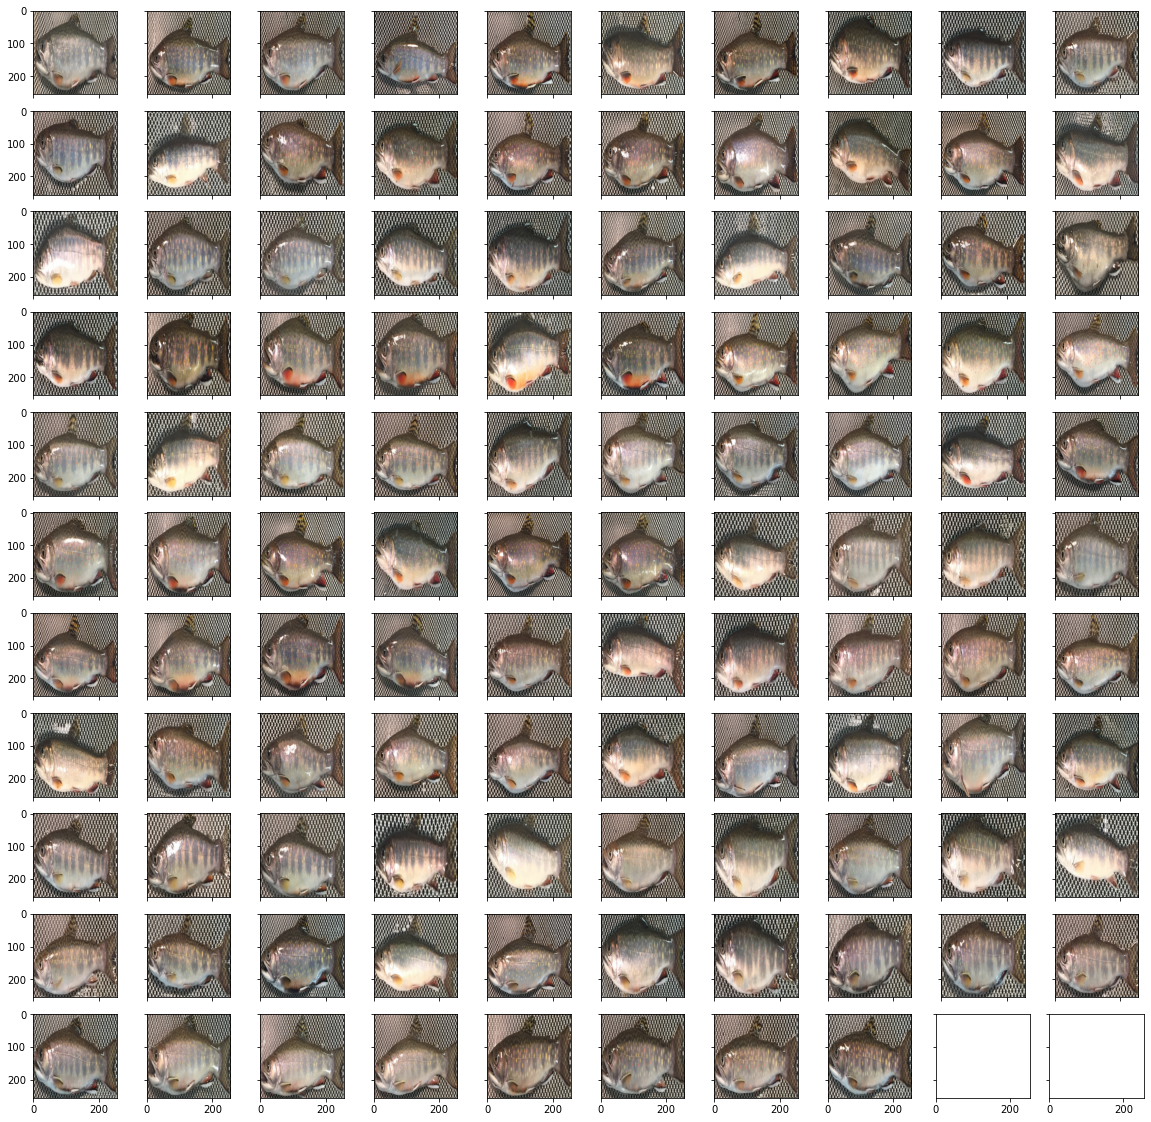

In [14]:
# Plot training images
colnum = 10
fig, ax = plt.subplots(int(np.ceil(X_train.shape[0] / colnum )), colnum, sharex='col', sharey='row', figsize=(20, 20))

# axes are in a two-dimensional array, indexed by [row, col]
for i in range(int(np.ceil(X_train.shape[0] / colnum ))):
    for j in range(colnum):
        # need to skip indices of images in the last row
        if (i == int(np.ceil(X_train.shape[0]) / colnum) and (j >= (X_train.shape[0] % colnum))):
            continue
        else:
            ax[i, j].imshow(X_train[i*colnum + j])

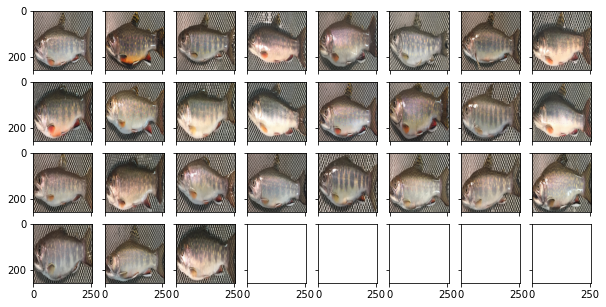

In [15]:
# Plot validation images
colnum = 8
fig, ax = plt.subplots(int(np.ceil(X_val.shape[0] / colnum )), colnum, sharex='col', sharey='row', figsize=(10, 5))

# axes are in a two-dimensional array, indexed by [row, col]
for i in range(int(np.ceil(X_val.shape[0] / colnum ))):
    for j in range(colnum):
        # need to skip indices of images in the last row
        if (i == int(np.ceil(X_val.shape[0]) / colnum) and (j >= (X_val.shape[0] % colnum))):
            continue
        else:
            ax[i, j].imshow(X_val[i*colnum + j])

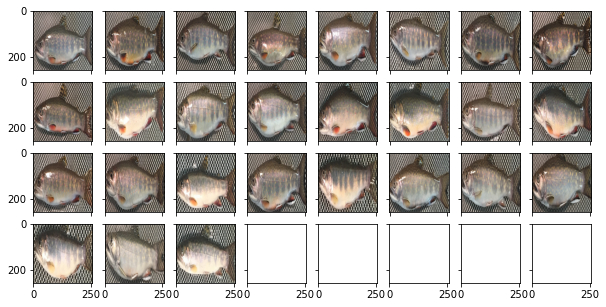

In [16]:
# Plot test images
colnum = 8
fig, ax = plt.subplots(int(np.ceil(X_test.shape[0] / colnum )), colnum, sharex='col', sharey='row', figsize=(10, 5))

# axes are in a two-dimensional array, indexed by [row, col]
for i in range(int(np.ceil(X_test.shape[0] / colnum ))):
    for j in range(colnum):
        # need to skip indices of images in the last row
        if (i == int(np.ceil(X_test.shape[0]) / colnum) and (j >= (X_test.shape[0] % colnum))):
            continue
        else:
            ax[i, j].imshow(X_test[i*colnum + j])

## Data Augmentation

In [17]:
datagen = ImageDataGenerator(
        featurewise_center = False, 
#       zca_whitening = True,
        featurewise_std_normalization = False,
        rotation_range = 90,
        samplewise_center = False,
        width_shift_range = 0,
        height_shift_range = 0,
        rescale = 1,
        shear_range = 0,
        zoom_range = 0, ###
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'nearest')

# zca_whitening overrides setting of `featurewise_std_normalization`

In [18]:
# fit parameters from data to the generator
datagen.fit(X_train)

# initialize the output arrays as the 'real' inputs (which we append our generated data to)
x_batches = X_train
y_batches = y_train 

In [19]:
%%time
# Data augmentation

# stolen from some website - credit?
# this extends training dataset
# loop through .flow() function to generate batches of modified training data

epochs = 25
for e in range(epochs):
    batches = 0
    per_batch = epochs
    for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size = per_batch):
        x_batches = np.concatenate((x_batches, x_batch), axis = 0)
        y_batches = np.concatenate((y_batches, y_batch), axis = 0)
        batches += 1       
        if batches >= len(X_train) / per_batch:
            # we need to break the loop by hand because the generator loops indefinitely
            break

# consider setting batch_size = X rather than loop

CPU times: user 1min 30s, sys: 1min 26s, total: 2min 56s
Wall time: 2min 56s


In [20]:
# augmented training data
X_train = x_batches
y_train = y_batches
print(X_train.shape)
print(y_train.shape)
print(f"{X_train.shape[0]} images in augmented dataset")

(2808, 256, 256, 3)
(2808,)
2808 images in augmented dataset


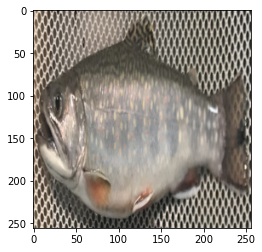

In [21]:
# show an example image from augmented dataset
plt.imshow(X_train[0])

In [22]:
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)
print('shape of train image: ', X_train[0].shape)
print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)
print('X val shape: ', X_val.shape)
print('y val shape: ', y_val.shape)

X train shape:  (2808, 256, 256, 3)
y train shape:  (2808,)
shape of train image:  (256, 256, 3)
X test shape:  (27, 256, 256, 3)
y test shape:  (27,)
X val shape:  (27, 256, 256, 3)
y val shape:  (27,)


In [23]:
# make y categorical
num_classes = 27
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(2808, 256, 256, 3)
(27, 256, 256, 3)
(27, 256, 256, 3)


In [25]:
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(2808, 27)
(27, 27)
(27, 27)


**A ResNet model to classify individual fish ID (0,...,26)**

In [26]:
tf.keras.backend.clear_session()

# Transfer learning using ResNet pre-trained model with ImageNet weights
# don't include the top layers (dense layers) because it used for classify 6000 classes on imagenet data set
# input will take <width x height> RGB images (3 channels)

base_model = resnet_v2.ResNet50V2(weights='imagenet', include_top=False, input_shape=(width, height, 3), pooling=None)

# add new layers for fish detection 
# GlobalAveragePooling2D will average the output of ResNet and provide 1D Tensor
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with 1024 hidden units and ReLU activation 
x = Dense(1024, activation='relu')(x)

# Set drop-out rate
dr = 0.3 # default = 0.3
x = Dropout(dr)(x) # if increase: brings train #s down

# Add a final sigmoid layer for classification
# output layer has number of neurons equal to the number of classes (27 fish ID in this case)
# predictions = Dense(num_classes, activation='sigmoid')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# model we will train
model = Model(inputs = base_model.input, outputs = predictions)

# RMSprop optimizer will adapt the learning rate
lr = 0.0001 # set learning rate...consider learning rate scheduler
model.compile(optimizer = RMSprop(lr = lr),
              loss = 'categorical_crossentropy', # requires 1hot encoded
              metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

**Train the Model**

In [27]:
filepath = 'weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint] # consider adding learning rate scheduler with early stopping fx

In [28]:
# Train the Model
epochs = 30

history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
#                   steps_per_epoch = 100,
                    epochs = epochs,
#                   validation_steps = 50,
#                   verbose = 2,
                    callbacks = callbacks_list)

Epoch 1/30
88/88 [==============================] - ETA: 0s - loss: 1.5093 - accuracy: 0.6172
Epoch 00001: val_accuracy improved from -inf to 0.44444, saving model to weights-improvement-01-0.44.hdf5
88/88 [==============================] - 198s 2s/step - loss: 1.5093 - accuracy: 0.6172 - val_loss: 2.4812 - val_accuracy: 0.4444
Epoch 2/30
88/88 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9840
Epoch 00002: val_accuracy improved from 0.44444 to 0.48148, saving model to weights-improvement-02-0.48.hdf5
88/88 [==============================] - 66s 749ms/step - loss: 0.0744 - accuracy: 0.9840 - val_loss: 2.2284 - val_accuracy: 0.4815
Epoch 3/30
88/88 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9872
Epoch 00003: val_accuracy improved from 0.48148 to 0.59259, saving model to weights-improvement-03-0.59.hdf5
88/88 [==============================] - 66s 749ms/step - loss: 0.0401 - accuracy: 0.9872 - val_loss: 1.9290 - val_accuracy: 0.5926


**Test the best model**

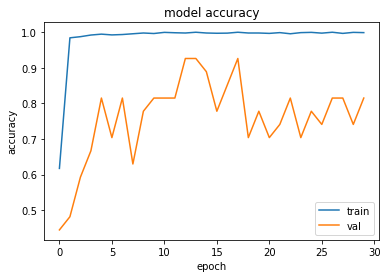

In [29]:
# accuracy per epoch of training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.savefig('PlotAcc.jpg')
plt.show()

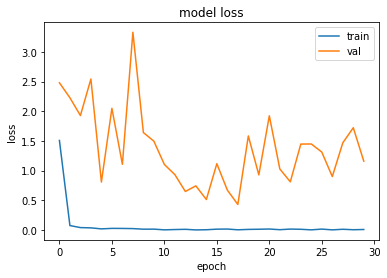

In [30]:
# loss per epoch of training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('PlotLoss.jpg')
plt.show()

In [32]:
# Load wieghts for the best model
model.load_weights('/home/jovyan/IndID_BKT1/weights-improvement-13-0.93.hdf5')

In [33]:
# Confusion matrix 
y_pred = model.predict(X_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
df_cm = pd.DataFrame(matrix, range(num_classes), range(num_classes))
np.savetxt("ModelCM.csv", df_cm, delimiter=",")

In [ ]:
# Strategies for dealing with out-of-training samples
# model.predict_proba(X_test) # yields final layer softmax scores [nrow=X_test rows, ncol= # fish [27]]
# results will be unscaled (perhaps including neg #s)...apply z-score or whatnot to interpret 

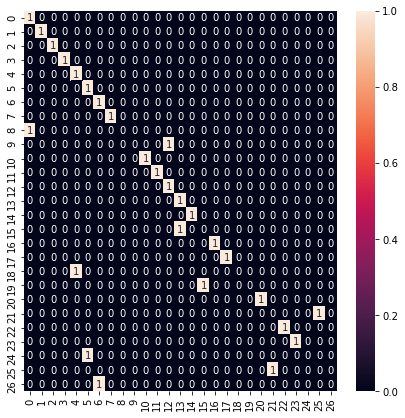

In [34]:
plt.figure(figsize = (7, 7))
sn.heatmap(df_cm, annot = True)
plt.savefig('PlotCM.jpg')
plt.show()

In [35]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', round(score[0],3))
print('Test accuracy:', round(score[1],3))

Test loss: 1.315
Test accuracy: 0.667


In [36]:
# Save model settings and results
import csv

trainacc = []
trainacc = history.history['accuracy']
np.savetxt("trainacc.csv", trainacc, header="TrainAcc", delimiter=",")

valacc = []
valacc = history.history['val_accuracy']
np.savetxt("valacc.csv", valacc, header="ValAcc", delimiter=",")

trainloss = []
trainloss = history.history['loss']
np.savetxt("trainloss.csv", trainloss, header="TrainLoss", delimiter=",")

valloss = []
valloss = history.history['val_loss']
np.savetxt("valloss.csv", valloss, header="ValLoss", delimiter=",")

# Testing data: loss and accuracy
fields = ["TestLoss", "TestAccuracy","Training image count","LearningRate","DropoutRate"]
with open('ModelResults.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',')
    csvwriter.writerow(fields)
    csvwriter.writerow([round(score[0],3), round(score[1],3), X_train.shape[0], lr, dr])